In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from functools import partial
import matplotlib.pyplot as plt

%matplotlib inline

### Assignment 1

In [2]:
ds1 = pd.read_csv('ds-boot-2.csv', sep='\t')
ds1.head()

,id,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p24,p25,p26,p27,p28,y1,y2,y3,y4,y5
0,11,6.48148,3.0,5.0,7.75000,0.0,7.16667,8.16667,9.66667,6.16667,...,1.66667,3.16667,0.0,0.00000,0.0,1.0,5.00,7.44,1.18,4.38
1,12,5.74074,4.0,8.0,7.33333,8.0,8.83333,9.75000,9.66667,9.00000,...,2.50000,5.50000,5.0,8.66667,8.0,4.5,4.25,8.93,2.00,6.03
2,25,7.59259,7.0,8.0,7.66667,8.0,9.66667,9.50000,6.16667,9.66667,...,3.50000,3.50000,9.0,6.50000,7.0,7.5,11.00,8.97,2.00,9.12
3,31,5.96297,4.0,8.0,9.33333,10.0,9.33333,7.00000,8.50000,9.66667,...,0.00000,0.00000,0.0,0.00000,0.0,4.0,6.25,8.93,1.82,6.41
4,48,5.44444,1.0,3.5,6.41667,9.0,8.50000,7.08333,6.33333,9.00000,...,0.00000,0.00000,0.0,0.00000,0.0,0.0,3.00,8.08,1.36,3.67


In [3]:
def bootstrap_from_data(data_frame, count):
    int_rv = st.randint(0, data_frame.shape[0])
    sample_idxs = int_rv.rvs(count)
    
    return data_frame.iloc[sample_idxs]

In [4]:
def find_conf_interval(init_params, bs_params, conf_level=0.05):
    delta = init_params - bs_params
    
    percentiles = np.percentile(delta,
                                [(conf_level / 2.) * 100, (1. - conf_level / 2.) * 100],
                                axis=0)
    
    conf_interval = (init_params - percentiles[1], init_params - percentiles[0])
    
    return conf_interval

In [5]:
B = 100

#### Estimating mean and median for $y_i$

In [6]:
yis = ds1.as_matrix(columns=['y{}'.format(num) for num in range(1, 6)])
init_mean = np.mean(yis, axis=0)
init_median = np.median(yis, axis=0)

In [7]:
bs_yis = [bootstrap_from_data(ds1[['y{}'.format(num) for num in range(1, 6)]], ds1.shape[0]) for _ in range(B)]
bs_yis = np.array(list(map(lambda yis: yis.as_matrix(), bs_yis)))

bs_means = np.mean(bs_yis, axis=1)
bs_medians = np.median(bs_yis, axis=1)

mean_conf_interval = find_conf_interval(init_mean, bs_means, conf_level=0.05)
median_conf_interval = find_conf_interval(init_median, bs_medians, conf_level=0.05)

In [8]:
np.set_printoptions(precision=2)

print('Mean of the original sample: {}'.format(init_mean))
print('Mean confidence interval:\nFrom:{}\nTo:{}'
      .format(np.round(mean_conf_interval[0], 2).tolist(), np.round(mean_conf_interval[1], 2).tolist()))
print('Median of the original sample: {}'.format(init_median))
print('Median confidence interval:\nFrom:{}\nTo:{}'
      .format(np.round(median_conf_interval[0], 2).tolist(), np.round(median_conf_interval[1], 2).tolist()))

Mean of the original sample: [ 4.03  5.51  7.31  1.53  5.63]
Mean confidence interval:
From:[3.19, 4.72, 6.37, 1.3, 4.84]
To:[4.78, 6.67, 8.21, 1.71, 6.46]
Median of the original sample: [ 4.    6.25  8.21  1.86  6.22]
Median confidence interval:
From:[2.74, 5.24, 7.99, 1.64, 5.34]
To:[5.64, 7.5, 8.93, 2.0, 7.28]


#### Estimating $y_i$ using linear regresion

Linear regression model:
$$y = \beta^T x + \epsilon \text{, where } \beta \in \mathbb{R}^{n+1} \text{, } \beta_{n+1} \text{ is intercept, so } x_{n+1}=1$$

In [9]:
def fit_for_yis(ds1, y_idxs):
    betas = []
    
    for y_idx in y_idxs:
        columns = ['p{}'.format(num) for num in range(1, 29)]
        X = ds1.as_matrix(columns)
        y = ds1.as_matrix(['y{}'.format(y_idx)])
        
        model = LinearRegression().fit(X, y)
        beta = np.concatenate([model.coef_.squeeze(), model.intercept_])
        betas.append(beta)
    
    return np.array(betas)

In [10]:
betas_init = fit_for_yis(ds1, range(1, 6))

bs_betas = [fit_for_yis(bootstrap_from_data(ds1, ds1.shape[0]), range(1, 6)) for _ in range(B)]
bs_betas = np.stack(bs_betas)

conf_interval = find_conf_interval(betas_init, bs_betas, conf_level=0.05)

np.set_printoptions(precision=2)

print('beta for y0 for p from 1 to 7 of the original sample:\n{}'.format(betas_init[0, :7]))
print('beta for y0 for p from 1 to 7 confidence interval:\nFrom:{}\nTo:{}'
      .format(np.round(conf_interval[0][0, :7], 2).tolist(), np.round(conf_interval[1][0, :7], 2).tolist()))

beta for y0 for p from 1 to 7 of the original sample:
[ 0.35 -0.09 -0.47  1.12 -0.33  0.92 -1.07]
beta for y0 for p from 1 to 7 confidence interval:
From:[-0.19, -0.55, -1.1, -0.03, -0.95, -0.46, -1.28]
To:[1.17, 0.51, 0.51, 1.25, 0.3, 1.3, 0.27]


### Assignment 2

In [11]:
bugs = pd.read_csv('ds-boot-1.csv', sep='\t')
bugs.head()

,day,bugsPerDay,cummBugs
0,1,0,0
1,2,1,1
2,3,0,1
3,4,2,3
4,5,1,4


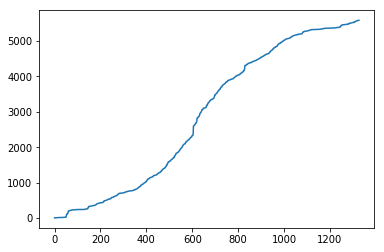

In [12]:
plt.plot(bugs['cummBugs'])

#### MLE derivation for G-O S-shaped model as an example

Let's assume our noise is Gaussian, so we can define MLE task as the following:
$$a \text{, } b=argmax_{a,b}{L(a,b,\sigma)} \text{, where } L(a,b,\sigma)=\Big(\frac{1}{2\pi\sigma^2}\Big)^{n/2} e^{\sum_{i=1}^{n}(-(y_i-a(1-(1+bt_i)e^{-bt_i}))^2)/(2\sigma^2)} \text{, } a \geq 0 \text{, } b > 0$$

Which can be transformed into maximum log-likelihood estimation:
$$log(L(a,b,\sigma))=-\frac{n}{2}log(2\pi\sigma^2) -\frac{1}{2\sigma^2}\sum_{i=1}^{n}(y_i-a(1-(1+bt_i)e^{-bt_i}))^2$$

Finally, our function will be the following:
$$a \text{, } b=argmax_{a,b}{L(a,b,\sigma)}=argmax_{a,b}{log(L(a,b))}=-\sum_{i=1}^{n}(y_i-a(1-(1+bt_i)e^{-bt_i}))^2$$

We got sum of squares! It was obvious for MLE with Gaussian distributions but I forgot about that. So, good practice. Now we can put any model into the last equation.

In [13]:
def s_shape_go(a, b, t):
    return a*(1. - (1 + b*t) * np.exp(-b*t))

def s_shape_go_mle(x, y, t):
    # a = x[0], b = x[1]
    
    return np.sum(np.power(y - s_shape_go(x[0], x[1], t), 2))

def s_shape_gompertz(a, b, c, t):
    return a*np.power(b, np.power(c, t))

def s_shape_gompertz_mle(x, y, t):
    # a = x[0], b = x[1], c = x[2]
    
    return np.sum(np.power(y - s_shape_gompertz(x[0], x[1], x[2], t), 2))

def s_shape_raleigh(a, r, alpha, beta, t):
    return a*(1. - np.exp(-r*alpha*(1 - np.exp(-beta*t**2/2.))))

def s_shape_raleigh_mle(x, y, t):
    # a = x[0], r = x[1], alpha = x[2], beta = x[3]
    
    return np.sum(np.power(y - s_shape_raleigh(x[0], x[1], x[2], x[3], t), 2))

In [25]:
def fit_model(func, mle_func, start_point, bugs, plot_title=None, save_plot_path=None):
    s_shape_min_func = partial(mle_func, y=bugs['cummBugs'], t=bugs['day'])
    res = minimize(s_shape_min_func, start_point, method='nelder-mead')
    print('Optimal parameters: {}. Gonverged: {}'.format(res.x, res.success))
    
    t = bugs['day']
    plt.plot(t, func(*res.x, t=t), label='Estimated')
    plt.plot(bugs['cummBugs'], label='Original data')
    plt.xlabel('Days')
    plt.ylabel('Cummulative amount of bugs')
    if plot_title is not None:
        plt.title(plot_title)
    plt.legend()
    
    if save_plot_path is not None:
        plt.savefig(save_plot_path)

#### Try to fit G-O S-shaped model

Optimal parameters: [  8.54e+03   1.86e-03]. Gonverged: True


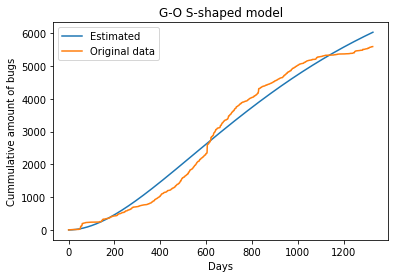

In [26]:
fit_model(s_shape_go, s_shape_go_mle, np.array([5500, 3*1e-3]), bugs,
          plot_title='G-O S-shaped model', save_plot_path='results/go_s_shape.png')

#### Try to fit Gompertz S-shaped model

Optimal parameters: [  6.03e+03   7.88e-04   9.96e-01]. Gonverged: True


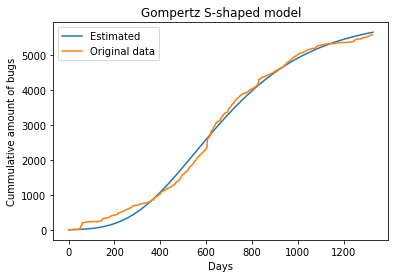

In [27]:
fit_model(s_shape_gompertz, s_shape_gompertz_mle, np.array([5500., 0.001, 0.995]), bugs,
          plot_title='Gompertz S-shaped model', save_plot_path='results/gompertz_s_shape.png')

#### Try to fit Raleigh S-shaped model

Optimal parameters: [  2.81e+08   6.59e-02   3.35e-04   3.04e-06]. Gonverged: True


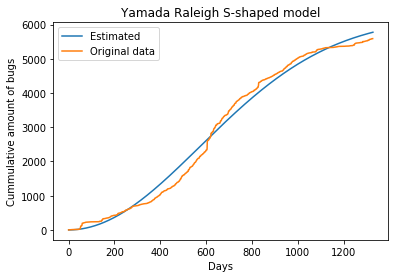

In [28]:
fit_model(s_shape_raleigh, s_shape_raleigh_mle, np.array([5e+8, 1e-1, 1e-03, 5e-06]), bugs,
         plot_title='Yamada Raleigh S-shaped model', save_plot_path='results/raleigh_s_shape.png')

In [21]:
def bootstrap_bugs(bugs, count):
    int_rv = st.randint(0, bugs.shape[0])
    sample_idxs = int_rv.rvs(count)
    
    new_bugs = pd.DataFrame(columns=['day', 'bugsPerDay', 'cummBugs'])
    new_bugs['bugsPerDay'] = bugs['bugsPerDay'].iloc[sample_idxs]
    new_bugs['day'] = bugs['day'].sort_values().tolist()
    new_bugs = new_bugs.sort_values(by=['day'])
    new_bugs['cummBugs'] = new_bugs['bugsPerDay'].cumsum()
    new_bugs = new_bugs.reset_index(drop=True)
    
    return new_bugs

def estimate_params(mle_func, bugs, start_point):
    s_shape_min_func = partial(mle_func, y=bugs['cummBugs'], t=bugs['day'])
    res = minimize(s_shape_min_func, start_point, method='nelder-mead')
    
    return res.x

def run_parameters_estimation(mle_func, bugs, start_point):
    # Calculate parameters of S-shape model based on initial sample
    init_params = estimate_params(mle_func=mle_func,
                          bugs=bugs,
                          start_point=start_point)

    # Calculate parameters of S-shape model based on B bootstrap samples
    bs_params = [estimate_params(mle_func=mle_func,
                              bugs=bootstrap_bugs(bugs, count=bugs.shape[0]),
                              start_point=start_point) for _ in range(B)]
    bs_params = np.array(bs_params)
    
    params_conf_interval = find_conf_interval(init_params, bs_params, conf_level=0.05)

    print('Parameters from initial sample: {}'.format(np.round(init_params, 4).tolist()))
    print('Bootstrap confidence interval for parameters:\nFrom: {}\nTo: {}'
          .format(np.round(params_conf_interval[0], 4).tolist(), np.round(params_conf_interval[1], 4).tolist()))

#### Estimate a, b parameters of G-O S-shaped model

In [22]:
run_parameters_estimation(s_shape_go_mle, bugs, np.array([5500, 3*1e-3]))

Parameters from initial sample: [8541.1262, 0.0019]
Bootstrap confidence interval for parameters:
From: [5729.6659, 0.0018]
To: [8230.305, 0.0027]


#### Estimate a, b, c parameters of Gompertz S-shape model

In [23]:
run_parameters_estimation(s_shape_gompertz_mle, bugs, np.array([5500., 0.001, 0.995]))

Parameters from initial sample: [6031.5207, 0.0008, 0.9964]
Bootstrap confidence interval for parameters:
From: [6232.21, 0.0295, 0.9978]
To: [9433.5938, 0.0616, 0.9987]


#### Estimate a, r, alpha, beta parameters of Raleigh S-shape model

In [24]:
run_parameters_estimation(s_shape_raleigh_mle, bugs, np.array([5e+8, 1e-1, 1e-03, 5e-06]))

Parameters from initial sample: [281352680.9316, 0.0659, 0.0003, 0.0]
Bootstrap confidence interval for parameters:
From: [29214103.7872, 0.0058, 0.0, 0.0]
To: [1104614364.766, 0.4071, 0.0011, 0.0]
